
🔁 Combo 1 → Train:Test = 10:90
 Epoch 1/2, Loss: 6.3955
 Epoch 2/2, Loss: 5.9667
806/806 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
✅ Finished Combo 1: Accuracy=0.8915, F1 Class 0=0.8290, F1 Class 1=0.9205


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


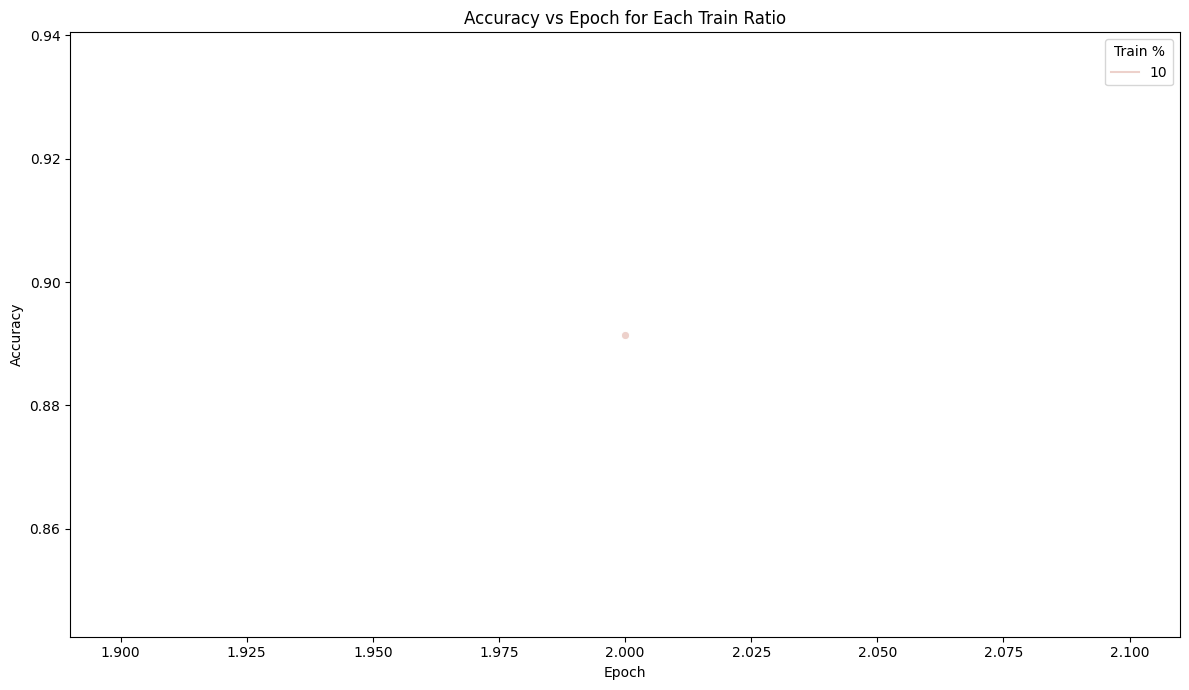

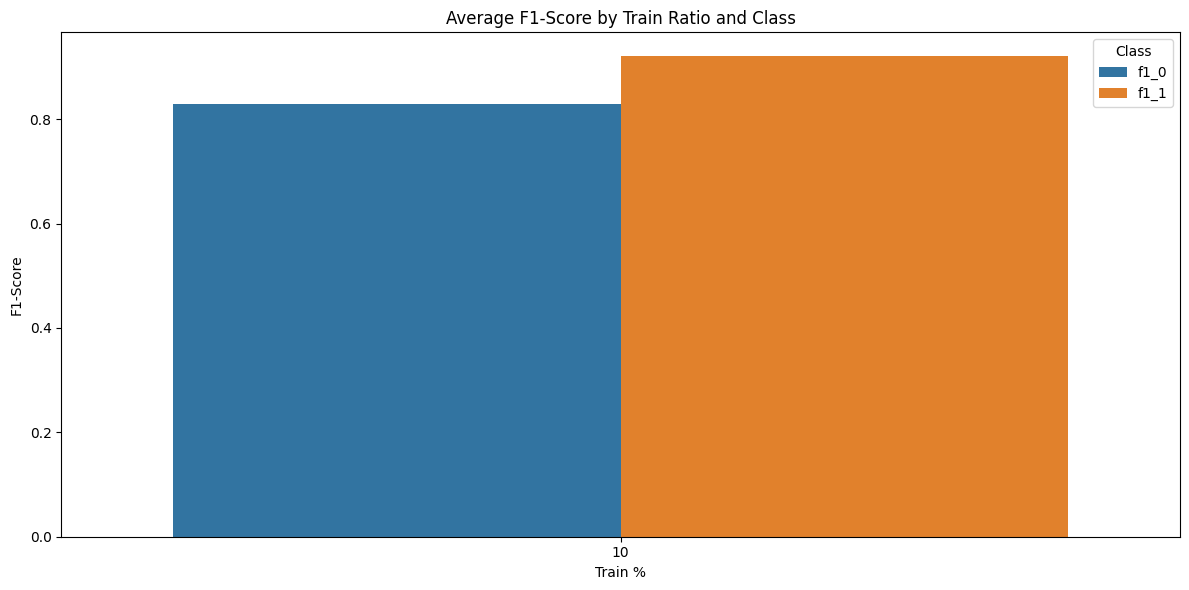

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


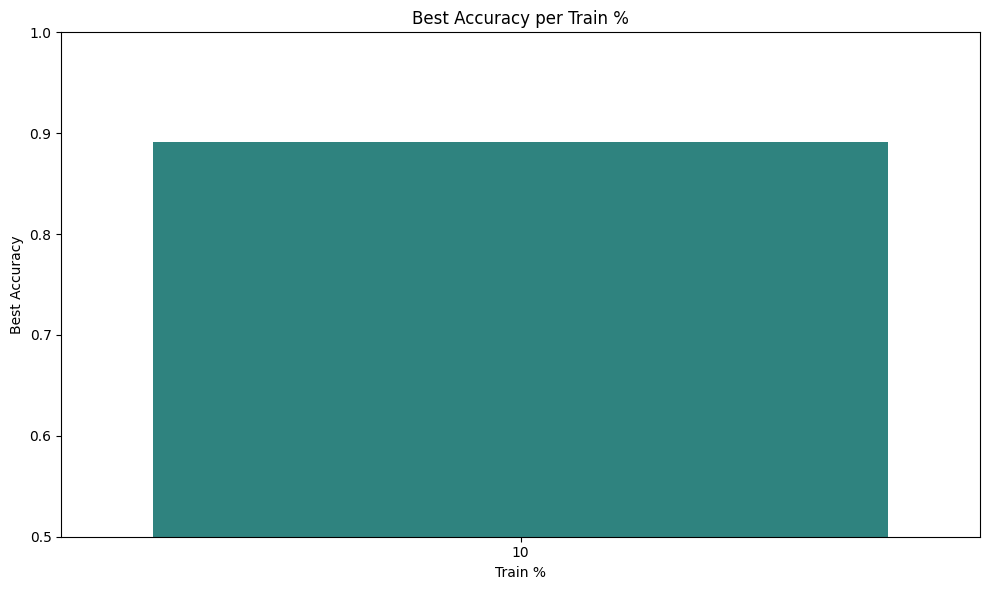

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Load and Prepare Data
# -------------------------------
train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])
df = df.drop(columns=["id", "attack_cat"], errors="ignore")

for col in ['proto', 'service', 'state']:
    df[col] = pd.factorize(df[col])[0]

X = df.drop(columns=["label"])
y = df["label"]

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# -------------------------------
# Step 2: MoCo Model Components
# -------------------------------
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    projection = layers.Dense(64)(x)
    return models.Model(inputs, projection)

def contrastive_loss(query, key, queue, temperature=0.07):
    query = tf.math.l2_normalize(query, axis=1)
    key = tf.math.l2_normalize(key, axis=1)
    queue = tf.math.l2_normalize(queue, axis=1)

    l_pos = tf.reshape(tf.reduce_sum(query * key, axis=1), [-1, 1])
    l_neg = tf.matmul(query, queue, transpose_b=True)
    logits = tf.concat([l_pos, l_neg], axis=1) / temperature
    labels = tf.zeros(logits.shape[0], dtype=tf.int32)
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits))

def augment_tabular(X, mask_prob=0.15, noise_std=0.05):
    mask = (np.random.rand(*X.shape) > mask_prob).astype(np.float32)
    noise = np.random.normal(0, noise_std, size=X.shape).astype(np.float32)
    return X * mask + noise

@tf.function
def momentum_update(query_encoder, key_encoder, m=0.999):
    for q, k in zip(query_encoder.trainable_variables, key_encoder.trainable_variables):
        k.assign(m * k + (1 - m) * q)

class MoCoQueue:
    def __init__(self, dim=64, size=8192):
        self.queue = tf.Variable(tf.random.normal([size, dim]), trainable=False)
        self.queue.assign(tf.math.l2_normalize(self.queue, axis=1))
        self.ptr = tf.Variable(0, trainable=False, dtype=tf.int32)
        self.size = size

    @tf.function
    def enqueue(self, keys):
        batch_size = tf.shape(keys)[0]
        idx = tf.range(self.ptr, self.ptr + batch_size) % self.size
        self.queue.scatter_nd_update(tf.expand_dims(idx, 1), keys)
        self.ptr.assign((self.ptr + batch_size) % self.size)

    def get(self):
        return self.queue

# -------------------------------
# Step 3: Run MoCo + SVM
# -------------------------------
def run_moco_svm(X, y, ratios, epochs=2, batch_size=512):
    results = []
    combo_id = 1

    for train_pct, test_pct in ratios:
        print(f"\n🔁 Combo {combo_id} → Train:Test = {train_pct}:{test_pct}")
        X_train, X_test, y_train, y_test = train_test_split(
            X.astype(np.float32), y,
            test_size=test_pct / 100, stratify=y, random_state=42
        )

        encoder = build_encoder(X_train.shape[1])
        key_encoder = build_encoder(X_train.shape[1])
        for q, k in zip(encoder.variables, key_encoder.variables):
            k.assign(q)

        optimizer = tf.keras.optimizers.Adam(3e-4)
        queue = MoCoQueue()

        for epoch in range(epochs):
            idx = np.random.permutation(X_train.shape[0])
            X_shuffle = X_train[idx]

            for i in range(0, len(X_shuffle), batch_size):
                batch = X_shuffle[i:i + batch_size]
                if batch.shape[0] < 2: continue
                x_q = augment_tabular(batch)
                x_k = augment_tabular(batch)

                with tf.GradientTape() as tape:
                    z_q = encoder(x_q, training=True)
                    z_k = key_encoder(x_k, training=False)
                    z_k = tf.stop_gradient(z_k)
                    loss = contrastive_loss(z_q, z_k, queue.get())

                grads = tape.gradient(loss, encoder.trainable_variables)
                optimizer.apply_gradients(zip(grads, encoder.trainable_variables))
                momentum_update(encoder, key_encoder)
                queue.enqueue(z_k)

            print(f" Epoch {epoch + 1}/{epochs}, Loss: {float(loss):.4f}")

        emb_train = encoder.predict(X_train)
        emb_test = encoder.predict(X_test)

        clf = SVC()
        clf.fit(emb_train, y_train)
        y_pred = clf.predict(emb_test)

        report = classification_report(y_test, y_pred, output_dict=True)

        results.append({
            'combo': combo_id,
            'train_pct': train_pct,
            'test_pct': test_pct,
            'epoch': epochs,
            'loss': float(loss),
            'accuracy': report['accuracy'],
            'f1_0': report['0']['f1-score'],
            'f1_1': report['1']['f1-score']
        })

        print(f"✅ Finished Combo {combo_id}: "
              f"Accuracy={report['accuracy']:.4f}, "
              f"F1 Class 0={report['0']['f1-score']:.4f}, "
              f"F1 Class 1={report['1']['f1-score']:.4f}")
        combo_id += 1

    return pd.DataFrame(results)
#, (20, 80),(30, 70), (40, 60), (50, 50), (60, 40), (70, 30), (80, 20), (90, 10)
# -------------------------------
# Step 4: Train + Save + Visualize
# -------------------------------
ratios = [(10, 90)]
results_df = run_moco_svm(X.values, y.values, ratios)
results_df.to_csv("moco_svm_results.csv", index=False)

# Plot Accuracy per Epoch
plt.figure(figsize=(12, 7))
sns.lineplot(data=results_df, x="epoch", y="accuracy", hue="train_pct", marker="o")
plt.title("Accuracy vs Epoch for Each Train Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Train %")
plt.tight_layout()
plt.show()

# Plot Average F1-Scores
avg_scores = results_df.groupby("train_pct")[["f1_0", "f1_1"]].mean().reset_index()
avg_scores = pd.melt(avg_scores, id_vars="train_pct", var_name="Class", value_name="F1-Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_scores, x="train_pct", y="F1-Score", hue="Class")
plt.title("Average F1-Score by Train Ratio and Class")
plt.xlabel("Train %")
plt.ylabel("F1-Score")
plt.tight_layout()
plt.show()

# Plot Best Accuracy
best_acc = results_df.groupby("train_pct")["accuracy"].max().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=best_acc, x="train_pct", y="accuracy", palette="viridis")
plt.title("Best Accuracy per Train %")
plt.xlabel("Train %")
plt.ylabel("Best Accuracy")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()